In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-01-07 08:58:18.194102


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ec3cf80a-8c38-e2fb-ee8f-425d6ea62063)
GPU 1: Tesla T4 (UUID: GPU-eb0c5e68-8e22-573d-f0ab-6794e98e0f79)


In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-07 08:58:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-07 08:58:20 (66.6 MB/s) - 'helper_functions.py' saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-01-07 08:58:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 172.253.119.207, 108.177.111.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: 'nlp_getting_started.zip'

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-01-07 08:58:34 (117 MB/s) - 'nlp_getting_started.zip' saved [607343/607343]



## Visualizing text dataset

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
@LT3dave so many specs so much fan service so much lore destruction

---

Target: 0 (not real disaster)
Text:
Those that I have sworn to defend have proven themselves to be friends of the House Hailstorm.

---

Target: 0 (not real disaster)
Text:
.@RaniaKhalek true. I faced everything from 'Is Bin Laden your uncle?' to 'Hopefully Afghanistan will be bombed'. Children can be very ugly.

---

Target: 0 (not real disaster)
Text:
Is it time to panic now? https://t.co/OrxDQfz0J0

---

Target: 0 (not real disaster)
Text:
I know where to go when the zombies take over!! http://t.co/hUTHXlkyxy

---



In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
text_vectorizer  = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [16]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
So much shit has happened today wtf idk how I survive thruuu it all        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  28,  187,  235,   41,  893,  124, 1235, 2934,   62,    8,  310,
        7582,   15,   44,    0]])>

In [20]:
# Get the unique words in the vocabular
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding Layer



In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Chances are many of us are still digging out from that catastrophe. THIS is why WoW NEEDS to evolve. THIS is why it can't be Vanilla anymore      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02296099, -0.01112924,  0.01758829, ...,  0.02598577,
         -0.00807564, -0.03825326],
        [-0.02942374, -0.00997287,  0.04533174, ..., -0.04937102,
          0.03351769,  0.03627009],
        [ 0.01770422,  0.04582072,  0.01426555, ..., -0.04363245,
          0.02268225,  0.02108167],
        ...,
        [ 0.0135545 ,  0.04998635,  0.04996851, ...,  0.04181379,
          0.04926785,  0.04078665],
        [-0.00793042, -0.02956261, -0.02080997, ..., -0.03202261,
          0.04205736,  0.02800033],
        [ 0.00344823,  0.04921139,  0.03340307, ...,  0.02405917,
         -0.03300016, -0.04955816]]], dtype=float32)>

In [23]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-2.29609851e-02, -1.11292377e-02,  1.75882913e-02, -4.36885022e-02,
        2.01822035e-02,  4.54980023e-02,  2.12294571e-02,  2.36862898e-03,
       -7.06420094e-03,  1.62458159e-02,  3.24241631e-02, -4.71850745e-02,
       -5.88176399e-03, -8.35249573e-03, -1.06333978e-02, -2.48533487e-03,
        3.59523296e-03, -4.74685207e-02,  3.60824354e-02, -6.54371828e-03,
       -8.73629004e-03,  1.15872845e-02, -4.37338464e-02,  8.96609947e-03,
       -2.59489547e-02, -2.38523968e-02, -3.52275372e-03, -2.20815893e-02,
        1.18532889e-02, -8.82232189e-03, -2.89746057e-02, -2.89843213e-02,
        1.21880881e-02,  1.60823017e-03, -4.82685938e-02, -1.18637308e-02,
       -2.01350451e-03, -4.20635231e-02, -2.21033581e-02, -4.17946093e-02,
       -1.43184066e-02, -3.04427389e-02,  2.78652050e-02,  4.83934768e-02,
       -2.68096086e-02, -1.13031380e-02,  8.25842470e-03,  4.83255424e-02,
        2.11215727e-02,  7.14306906e-03, -4.06945720

## Modelling a text dataset
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

## Model 0 : Naive Bayes

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert the words to numbers using tfidf
    ("clf",MultinomialNB()) # model the text
])
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Evaluation Function

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
# get baseline model results
baseline_results = calculate_results(y_true=val_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1 : Simple Dense Model

In [29]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "model_logs"

In [30]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

In [31]:
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [33]:
# Fit the model
model_1_history = model_1.fit(train_sentences,train_labels,
                             epochs=5,validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240107-085837
Epoch 1/5
215/215 [==============================] - 15s 60ms/step - loss: 0.6097 - accuracy: 0.6917 - val_loss: 0.5358 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4409 - accuracy: 0.8212 - val_loss: 0.4690 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3459 - accuracy: 0.8605 - val_loss: 0.4589 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2843 - accuracy: 0.8927 - val_loss: 0.4641 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2375 - accuracy: 0.9121 - val_loss: 0.4766 - val_accuracy: 0.7887


In [34]:
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7887


[0.476615846157074, 0.7887139320373535]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.03865973,  0.0059144 , -0.03930909, ...,  0.037049  ,
         -0.02633011,  0.04734522],
        [ 0.02964487, -0.0290021 , -0.03779221, ...,  0.00707794,
          0.02180275, -0.02551627],
        [ 0.02401848,  0.03416735, -0.00248485, ...,  0.05709871,
          0.05968646, -0.00109137],
        ...,
        [ 0.01959074, -0.04077123, -0.00555374, ...,  0.02518568,
          0.01297966,  0.0300954 ],
        [-0.01907508,  0.02873624, -0.07097641, ...,  0.00795686,
          0.08325677,  0.07646874],
        [-0.02325308,  0.0228009 , -0.04451038, ...,  0.08050133,
          0.09591407,  0.07753868]], dtype=float32)>]

In [36]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [37]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.409725  ],
       [0.74716616],
       [0.9976931 ],
       [0.10723679],
       [0.10852621],
       [0.9375999 ],
       [0.9102738 ],
       [0.99278015],
       [0.9675918 ],
       [0.26943552]], dtype=float32)

In [38]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7930566476728028,
 'recall': 0.7887139107611548,
 'f1': 0.7859560656123432}

In [40]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Model comparision funtion


In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.87, Difference: -0.39
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


## Visualize learned embeddings

In [42]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [44]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [45]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

## Model 2 : LSTM 

In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [47]:
# compile model
model_2.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
# fit the model_2
model_2_history = model_2.fit(train_sentences,train_labels,epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240107-085901
Epoch 1/5
215/215 [==============================] - 13s 46ms/step - loss: 0.5086 - accuracy: 0.7425 - val_loss: 0.4533 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3163 - accuracy: 0.8726 - val_loss: 0.5125 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2206 - accuracy: 0.9156 - val_loss: 0.5725 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1572 - accuracy: 0.9447 - val_loss: 0.6062 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1099 - accuracy: 0.9593 - val_loss: 0.9094 - val_accuracy: 0.7572


In [50]:
# make predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.01062967],
        [0.75416327],
        [0.9991467 ],
        [0.07532902],
        [0.0021694 ],
        [0.9993912 ],
        [0.8671985 ],
        [0.9995808 ],
        [0.99939704],
        [0.47039902]], dtype=float32))

In [51]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
model_2_results = calculate_results(val_labels,model_2_preds)
model_2_results

{'accuracy': 75.7217847769029,
 'precision': 0.7576149234046069,
 'recall': 0.7572178477690289,
 'f1': 0.7555947144839635}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Model 3 : GRU ( Gated Recurrent Unit)

In [54]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim = max_vocab_length,output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,name="embeddin_3")
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_GRU")

In [55]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embeddin_3 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [57]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240107-085923
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.5224 - accuracy: 0.7346 - val_loss: 0.4524 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3185 - accuracy: 0.8691 - val_loss: 0.4948 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2193 - accuracy: 0.9177 - val_loss: 0.5587 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1600 - accuracy: 0.9431 - val_loss: 0.6183 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1212 - accuracy: 0.9585 - val_loss: 0.6300 - val_accuracy: 0.7677


In [58]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


((762, 1),
 array([[0.29622543],
        [0.8506282 ],
        [0.99817204],
        [0.11355691],
        [0.00922895],
        [0.99419916],
        [0.69857544],
        [0.9982882 ],
        [0.9986237 ],
        [0.5278263 ]], dtype=float32))

In [59]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [60]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

In [61]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Model 4: Bidirectonal RNN model


In [62]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [63]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [65]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240107-085946
Epoch 1/5
215/215 [==============================] - 15s 49ms/step - loss: 0.5090 - accuracy: 0.7478 - val_loss: 0.4596 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3134 - accuracy: 0.8716 - val_loss: 0.5235 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2091 - accuracy: 0.9199 - val_loss: 0.5669 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1417 - accuracy: 0.9534 - val_loss: 0.6826 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1005 - accuracy: 0.9657 - val_loss: 0.6919 - val_accuracy: 0.7717


In [66]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.03954765],
       [0.80296403],
       [0.9996499 ],
       [0.10877933],
       [0.00927584],
       [0.9970907 ],
       [0.8534291 ],
       [0.9997397 ],
       [0.9996588 ],
       [0.15133296]], dtype=float32)

In [67]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [68]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'precision': 0.7726063176824562,
 'recall': 0.7716535433070866,
 'f1': 0.7699532001851459}

In [69]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.17, Difference: -2.10
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Model 5: Conv1D

In [70]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01472423,  0.04822134,  0.05038375, ...,  0.04127257,
           0.04792528,  0.04069852],
         [-0.04457895,  0.00641701, -0.05192732, ..., -0.00090376,
           0.07454678,  0.05864219],
         [-0.02668517, -0.02827318,  0.03179392, ..., -0.02783001,
          -0.00289628,  0.0163378 ],
         ...,
         [-0.03865973,  0.0059144 , -0.03930909, ...,  0.037049  ,
          -0.02633011,  0.04734522],
         [-0.03865973,  0.0059144 , -0.03930909, ...,  0.037049  ,
          -0.02633011,  0.04734522],
         [-0.03865973,  0.0059144 , -0.03930909, ...,  0.037049  ,
          -0.02633011,  0.04734522]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 8.93913060e-02, 5.95152490e-02, 4.03807387e-02,
          0.00000000e+00, 2.41054147e-02, 0.00000000e+00, 2.44942699e-02,
          2.

In [76]:
tf.random.set_seed(42)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,output_dim=128,
                                    embeddings_initializer="uniform",
                                    input_length=max_length,name="embedding_5")
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32,kernel_size=5,activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 1)              

In [77]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240107-090802
Epoch 1/5
215/215 [==============================] - 11s 45ms/step - loss: 0.5342 - accuracy: 0.7342 - val_loss: 0.4685 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3338 - accuracy: 0.8591 - val_loss: 0.5165 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2296 - accuracy: 0.9123 - val_loss: 0.5905 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1650 - accuracy: 0.9358 - val_loss: 0.6906 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1233 - accuracy: 0.9508 - val_loss: 0.7844 - val_accuracy: 0.7625


In [78]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.6483472 ],
       [0.82168514],
       [0.9999925 ],
       [0.019766  ],
       [0.01749879],
       [0.9821379 ],
       [0.7913184 ],
       [0.99954766],
       [0.9999976 ],
       [0.20501179]], dtype=float32)

In [79]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [80]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'precision': 0.7622420629158274,
 'recall': 0.7624671916010499,
 'f1': 0.7615230580020793}

In [81]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


## Pretrained Embeddings (transfer learnign for NLP)

## Model 6: TensorFlow Hub Pretrained Sentence Encoder


In [83]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [84]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [85]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240107-091421
Epoch 1/5
215/215 [==============================] - 7s 12ms/step - loss: 0.5030 - accuracy: 0.7865 - val_loss: 0.4494 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4148 - accuracy: 0.8142 - val_loss: 0.4381 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4003 - accuracy: 0.8212 - val_loss: 0.4337 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3931 - accuracy: 0.8251 - val_loss: 0.4290 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3869 - accuracy: 0.8297 - val_loss: 0.4302 - val_accuracy: 0.8150


In [86]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.13724087],
       [0.7350439 ],
       [0.9870811 ],
       [0.19909784],
       [0.7048489 ],
       [0.680969  ],
       [0.97923386],
       [0.97607654],
       [0.92552215],
       [0.08099547]], dtype=float32)

In [87]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1': 0.8134357776936025}

In [89]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


## Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data
 

In [90]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [91]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [92]:
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [93]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [94]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240107-092855
Epoch 1/5
22/22 [==============================] - 4s 41ms/step - loss: 0.6665 - accuracy: 0.7114 - val_loss: 0.6476 - val_accuracy: 0.6850
Epoch 2/5
22/22 [==============================] - 0s 19ms/step - loss: 0.5945 - accuracy: 0.8076 - val_loss: 0.5919 - val_accuracy: 0.7388
Epoch 3/5
22/22 [==============================] - 0s 19ms/step - loss: 0.5189 - accuracy: 0.8265 - val_loss: 0.5398 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4550 - accuracy: 0.8338 - val_loss: 0.5073 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4115 - accuracy: 0.8411 - val_loss: 0.4898 - val_accuracy: 0.7756


In [95]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.2550722 ],
       [0.78819454],
       [0.9066863 ],
       [0.31610674],
       [0.57435054],
       [0.8269822 ],
       [0.81024355],
       [0.8473559 ],
       [0.8469352 ],
       [0.1292761 ]], dtype=float32)

In [96]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [97]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7802047087708873,
 'recall': 0.7755905511811023,
 'f1': 0.7723569237171506}

In [98]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## Comparing the performance of each of our models


In [99]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.871391,0.793057,0.788714,0.785956
lstm,75.721785,0.757615,0.757218,0.755595
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,77.165354,0.772606,0.771654,0.769953
conv1d,76.246719,0.762242,0.762467,0.761523
tf_hub_sentence_encoder,81.496063,0.817255,0.814961,0.813436
tf_hub_10_percent_data,77.559055,0.780205,0.775591,0.772357


In [100]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

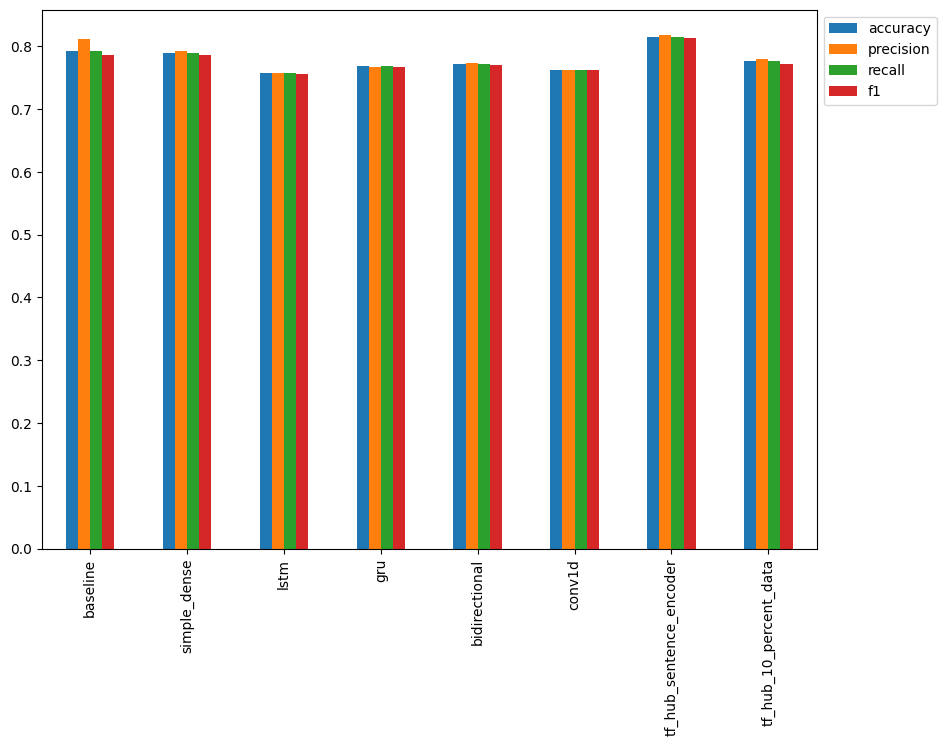

In [101]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

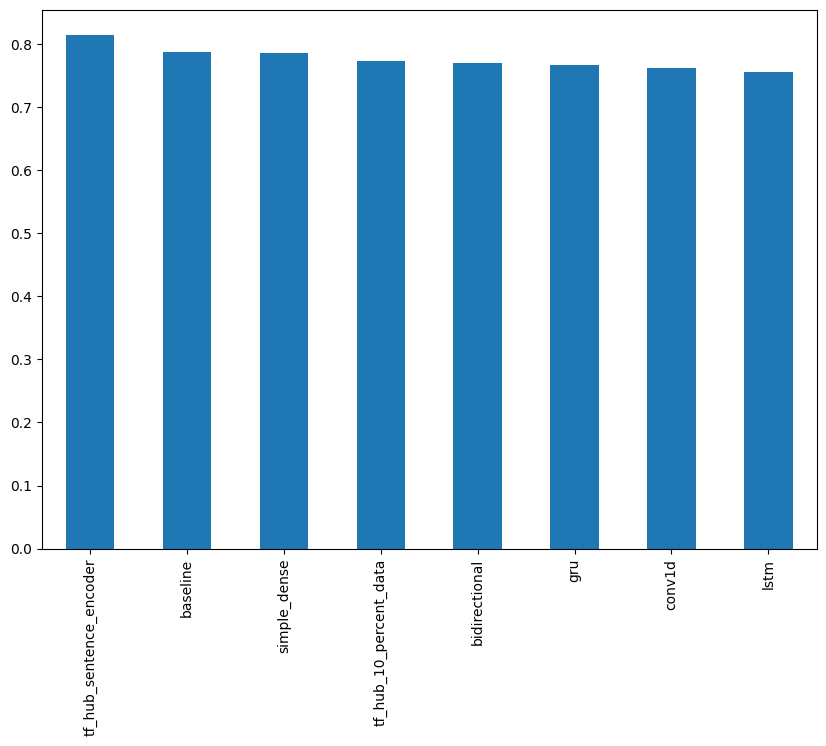

In [102]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Combining our models (model ensembling/stacking)
Combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

In [104]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [105]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.21522309711287,
 'precision': 0.7820002933865271,
 'recall': 0.7821522309711286,
 'f1': 0.7814160583740962}

In [106]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [110]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100.

/tmp/ipykernel_42/1361210806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100.


In [111]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.788714,0.793057,0.788714,0.785956
lstm,0.757218,0.757615,0.757218,0.755595
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.771654,0.772606,0.771654,0.769953
conv1d,0.762467,0.762242,0.762467,0.761523
tf_hub_sentence_encoder,0.814961,0.817255,0.814961,0.813436
tf_hub_10_percent_data,0.775591,0.780205,0.775591,0.772357
ensemble_results,78.215223,0.782000,0.782152,0.781416


## Saving the model

In [112]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [113]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [114]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4302 - accuracy: 0.8150


[0.4302287995815277, 0.8149606585502625]

## Finding the most wrong examples

In [115]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.137241
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.735044
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987081
3,@camilacabello97 Internally and externally scr...,1,0.0,0.199098
4,Radiation emergency #preparedness starts with ...,1,1.0,0.704849


In [116]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.908677
759,FedEx will no longer transport bioterror patho...,0,1.0,0.853226
628,@noah_anyname That's where the concentration c...,0,1.0,0.848929
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.840489
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.837081
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.827086
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.786306
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.783155
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.767602
695,A look at state actions a year after Ferguson'...,0,1.0,0.765328


In [117]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9086766839027405
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8532256484031677
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8489285707473755
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8404893279075623
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8370814919471741
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8270862102508545
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pr

In [118]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06090360879898071
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.059643518179655075
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.05631117522716522
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05560373514890671
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04832014814019203
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04373811557888985
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.039936672896146774
Text:
Reddit Will Now Qu

## Making predictions on the test dataset

In [119]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.18041811883449554
Text:
Overall the English lads did very well today. They need to pile on and get over 400 runs ahead and destroy...

----

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.45403996109962463
Text:
@snapharmony : People are finally panicking about cable TV http://t.co/boUa80Z5Wf

----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.05627875030040741
Text:
Reddit Will Now Quarantine Offensive Content via #Wired http://t.co/g8EF8dU9Cy

----

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.8945995569229126
Text:
30 Years After the Chernobyl Nuclear Disaster via @fubiz http://t.co/N4B59iqm94

----

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.11279156059026718
Text:
I think it's time for a cup of tea and a scone before I tackle the war zone that is is my bedroom. I wonder how many condom packets Ill find

----

1/1 [====

In [123]:
# Turn Tweet into string
random_tweet = "Earthquakes in Japan!! many buildings were shaken"

In [121]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [124]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=random_tweet)

1/1 [==============================] - 0s 36ms/step
Pred: 1.0 (real disaster) Prob: 0.9331342577934265
Text:
Earthquakes in Japan!! many buildings were shaken


## The speed/score tradeoff


In [125]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [126]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 8ms/step


(0.25897384300060367, 0.00033986068635249826)

In [127]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02074966200052586, 2.7230527559745223e-05)

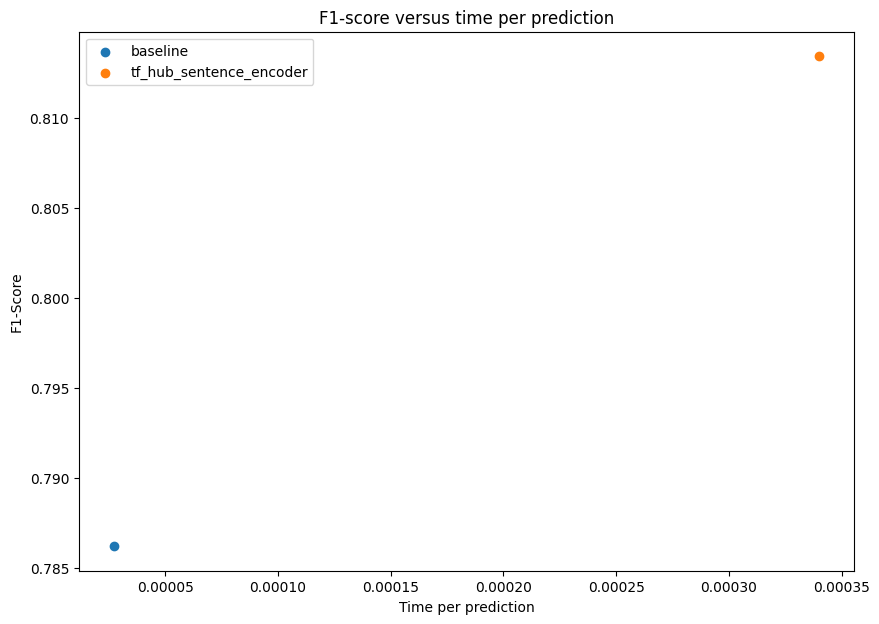

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");